In [11]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress

study_name = "lightgbm7"

df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
productos = pd.read_csv("../datasets/tb_productos.txt", sep="\t")
productos = productos.drop_duplicates(subset=["product_id"],keep="first")  # Eliminar duplicados por si acaso
stocks = pd.read_csv("../datasets/tb_stocks.txt", sep="\t")

productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
df = df[df["product_id"].isin(productos_ok["product_id"])]
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum","plan_precios_cuidados":"first"}).reset_index()


productos_list = df['product_id'].unique()
periodos = df['periodo'].unique()
idx = pd.MultiIndex.from_product([productos_list, periodos], names=['product_id', 'periodo'])
completo = idx.to_frame(index=False)
# 4 filtrar combinaciones periodo_producto
completo = completo.merge(df, on=['periodo', 'product_id'], how='left')
nacimiento_producto = df.groupby('product_id')['periodo'].min().rename('nacimiento_producto')

completo = completo.merge(nacimiento_producto, on='product_id', how='left')
completo = completo[completo['periodo'] >= completo['nacimiento_producto']]



df = pd.merge(completo, productos, how="left", on="product_id")
df = df.merge(stocks, how="left", on=["product_id", "periodo"])

df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

df["mes"] = df["periodo"].dt.month
df["year"] = df["periodo"].dt.year
df["quarter"] = df["periodo"].dt.quarter

# totales por cat1 por periodo
df["cat1_total"] = df.groupby(["periodo", "cat1"])["tn"].transform("sum")
# totales por cat2 por periodo
df["cat2_total"] = df.groupby(["periodo", "cat2"])["tn"].transform("sum")
# totales por cat3 por periodo
df["cat3_total"] = df.groupby(["periodo", "cat3"])["tn"].transform("sum")


# shift t-1 a t12
meses = ["tn"]
for i in range(1, 13):
    df[f"tn_t{i}"] = df.groupby("product_id")["tn"].shift(i)
    df[f"delta_t{i}"] = df[f"tn"] / df[f"tn_t{i}"]
    meses.append(f"tn_t{i}")
    df[f"cat1_t{i}"] = df.groupby("product_id")["cat1_total"].shift(i)
    df[f"cat2_t{i}"] = df.groupby("product_id")["cat2_total"].shift(i)
    df[f"cat3_t{i}"] = df.groupby("product_id")["cat3_total"].shift(i)
    
    
df["promedio_t12"] = df[meses].mean(axis=1)
df["promedio_t6"] = df[meses[:6]].mean(axis=1)

# Función para calcular la pendiente de una serie temporal
def calcular_pendiente(serie):
    datos = serie.dropna().values
    if len(datos) < 2:  # Mínimo 2 puntos para una regresión
        return np.nan
    x = np.arange(len(datos))  # [0, 1, 2, ..., n-1] (representa el tiempo)
    slope, _, _, _, _ = linregress(x, datos)
    return slope

# Aplicamos la función por grupo (producto) y reindexamos para alinear con df
df["pendiente_reg_12"] = (
    df.groupby("product_id")[meses]
    .apply(lambda grupo: grupo.apply(calcular_pendiente, axis=1))
    .reset_index(level=0, drop=True)  # Eliminamos el nivel de grupo para alinear índices
)

df['media_movil_3m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(3).mean())
df['media_movil_6m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(6).mean())
df['media_movil_12m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(12).mean())

# target t+2
df["target"] = df.groupby("product_id")["tn"].shift(-2)




cat_cols = ['cat1', 'cat2', 'cat3', 'brand', 'plan_precios_cuidados']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
del completo, productos, stocks
gc.collect()
df

,product_id,periodo,tn,plan_precios_cuidados,nacimiento_producto,cat1,cat2,cat3,brand,sku_size,...,cat1_t12,cat2_t12,cat3_t12,promedio_t12,promedio_t6,pendiente_reg_12,media_movil_3m,media_movil_6m,media_movil_12m,target
0,20001,2017-01-01,934.77222,0,201701,1,10,47,0,3000,...,NaN,NaN,NaN,934.772220,934.772220,NaN,NaN,NaN,NaN,1303.35771
1,20001,2017-02-01,798.01620,0,201701,1,10,47,0,3000,...,NaN,NaN,NaN,866.394210,866.394210,136.756020,NaN,NaN,NaN,1069.96130
2,20001,2017-03-01,1303.35771,0,201701,1,10,47,0,3000,...,NaN,NaN,NaN,1012.048710,1012.048710,-184.292745,1012.048710,NaN,NaN,1502.20132
3,20001,2017-04-01,1069.96130,0,201701,1,10,47,0,3000,...,NaN,NaN,NaN,1026.526858,1026.526858,-91.090875,1057.111737,NaN,NaN,1520.06539
4,20001,2017-05-01,1502.20132,0,201701,1,10,47,0,3000,...,NaN,NaN,NaN,1121.661750,1121.661750,-140.680330,1291.840110,NaN,NaN,1030.67391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22370,21087,2019-12-01,1.02205,0,201909,2,3,3,23,65,...,NaN,NaN,NaN,0.907423,0.907423,-0.265787,1.109907,NaN,NaN,NaN
22371,21214,2019-09-01,0.34250,0,201909,2,3,65,23,50,...,NaN,NaN,NaN,0.342500,0.342500,NaN,NaN,NaN,NaN,0.84012
22372,21214,2019-10-01,0.21735,0,201909,2,3,65,23,50,...,NaN,NaN,NaN,0.279925,0.279925,0.125150,NaN,NaN,NaN,0.24428
22373,21214,2019-11-01,0.84012,0,201909,2,3,65,23,50,...,NaN,NaN,NaN,0.466657,0.466657,-0.248810,0.466657,NaN,NaN,NaN


In [12]:
df_kgl = df[df["periodo"] == "2019-12-01"]
df_kgl["periodo"] = df_kgl["periodo"].astype(int)
df = df[~df["periodo"].isin(["2019-11-01", "2019-12-01"])]


C:\Users\carre\AppData\Local\Temp\ipykernel_17024\2505419454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kgl["periodo"] = df_kgl["periodo"].astype(int)
C:\Users\carre\AppData\Local\Temp\ipykernel_17024\2505419454.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df = df[~df["periodo"].isin(["2019-11-01", "2019-12-01"])]


In [13]:

# Separar features y target
X = df.drop(columns=["target"])
y = df["target"]
X_train = X[X["periodo"] < '2019-10-01']
X_train["periodo"] = X_train["periodo"].astype(int)
y_train = y[X["periodo"] < '2019-10-01']

X_val = X[X["periodo"] == '2019-10-01']
X_val["periodo"] = X_val["periodo"].astype(int)
y_val = y[X["periodo"] == '2019-10-01']



C:\Users\carre\AppData\Local\Temp\ipykernel_17024\4176657755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["periodo"] = X_train["periodo"].astype(int)
C:\Users\carre\AppData\Local\Temp\ipykernel_17024\4176657755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["periodo"] = X_val["periodo"].astype(int)


In [14]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

def custom_mape_loss(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    epsilon = np.finfo(float).eps  # Valor muy pequeño para evitar división por cero
    return numerator / (denominator + epsilon)

# === 2. Definición del objetivo para Optuna ===
def objective(trial):
    params = {
        "sample_weight": X_train["tn"].to_list(),
        "objective": "regression",
        "metric": ["rmse", "mape"],
        "boosting_type": "gbdt",
        "verbosity": -1,
        "n_jobs": -1,
        "seed": 42,
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 5.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 5.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "max_bin": trial.suggest_int("max_bin", 10, 2000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "path_smooth": trial.suggest_float("path_smooth", 0, 1),  # Nuevo parámetro útil
    }

    model = lgb.train(
        params,
        lgb.Dataset(X_train, label=y_train),
        valid_sets=[lgb.Dataset(X_val, label=y_val)],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    preds = model.predict(X_val)
    
    
    
    mape = custom_mape_loss(y_val, preds)
    # rmse = mean_squared_error(y_val, preds)
    # rmse = np.sqrt(rmse)
    
    #rmse = mean_squared_error(y_val, preds, squared=False)
    return mape

# === 3. Configurar almacenamiento SQLite para Optuna ===
os.makedirs("optuna_storage", exist_ok=True)
DB_PATH = "optuna_storage/optuna.db"
STUDY_NAME = study_name
storage_url = f"sqlite:///{DB_PATH}"

# === 4. Crear o cargar estudio ===
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

# === 5. Ejecutar optimización ===
study.optimize(objective, n_trials=150)

# === 6. Mostrar resultados ===
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor MAE: {study.best_value:.4f}")

[I 2025-07-12 01:52:32,797] A new study created in RDB with name: lightgbm7
[I 2025-07-12 01:52:37,339] Trial 0 finished with value: 0.2757287764662241 and parameters: {'num_leaves': 185, 'learning_rate': 0.07670438956994839, 'feature_fraction': 0.8666780597460709, 'bagging_fraction': 0.915290753193335, 'bagging_freq': 1, 'min_child_samples': 39, 'lambda_l1': 0.34887393940577843, 'lambda_l2': 3.2312397648245814, 'max_depth': 7, 'max_bin': 1878, 'min_data_in_leaf': 24, 'extra_trees': False, 'path_smooth': 0.09718751816644466}. Best is trial 0 with value: 0.2757287764662241.
[I 2025-07-12 01:52:40,734] Trial 1 finished with value: 0.29346073886988944 and parameters: {'num_leaves': 31, 'learning_rate': 0.008288470931048725, 'feature_fraction': 0.7700632011524733, 'bagging_fraction': 0.7527160453802625, 'bagging_freq': 1, 'min_child_samples': 37, 'lambda_l1': 0.0023619365087964397, 'lambda_l2': 0.02843908368547846, 'max_depth': 4, 'max_bin': 765, 'min_data_in_leaf': 188, 'extra_trees': Tru

Mejores hiperparámetros encontrados:
{'num_leaves': 103, 'learning_rate': 0.0853432148260185, 'feature_fraction': 0.6416786509776304, 'bagging_fraction': 0.8738054832631006, 'bagging_freq': 3, 'min_child_samples': 19, 'lambda_l1': 0.2408488277548435, 'lambda_l2': 0.016328068146628127, 'max_depth': 10, 'max_bin': 958, 'min_data_in_leaf': 143, 'extra_trees': False, 'path_smooth': 0.9448376071461212}
Mejor MAE: 0.2404


In [18]:
best_params = study.best_params.copy()
best_params.update({
    "objective": "regression",
    "metric": ["rmse", "mape"],
    "verbosity": -1,
    "n_jobs": -1,
    "seed": 42
})

model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Asegurar las mismas columnas
X_kgl = df_kgl[X_train.columns]  # Misma estructura

# === 9. Hacer predicción sobre nuevos datos ===
preds_kgl = model.predict(X_kgl)


In [19]:
result = pd.DataFrame({"product_id": X_kgl["product_id"],  "tn": preds_kgl})

result = result[result["product_id"].isin(productos_ok["product_id"])]

result

,product_id,tn
35,20001,1298.819178
71,20002,1108.197256
107,20003,886.444030
143,20004,661.420856
179,20005,639.854462
...,...,...
22358,20962,2.343861
22362,20975,2.247746
22366,20995,2.224461
22370,21087,1.484249


In [20]:
result.to_csv(f"{study_name}.csv",sep=',', index=False)

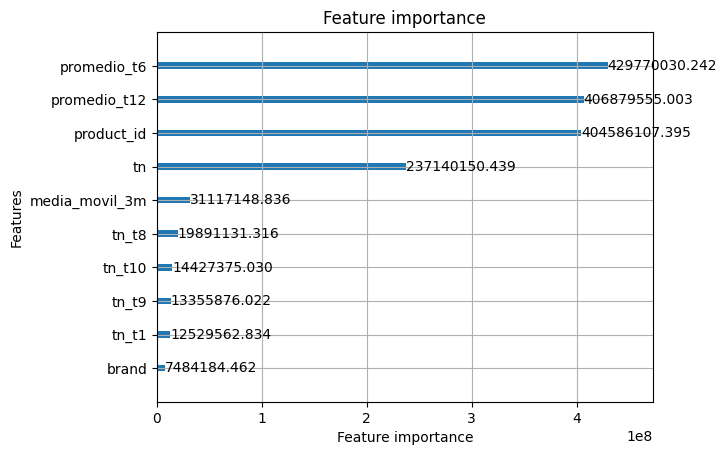

In [24]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance  # Importación específica
# Visualizar importancia de características
plot_importance(model, importance_type='gain', max_num_features=10)  # Usar la función importada
plt.show()